<a href="https://colab.research.google.com/github/abhilash1910/AI-Geometric-Learning/blob/master/Chapter_2_Understanding_the_data/Intrinsic_Mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Intrinsic Mean 

Given a set of points $x_{1},x_{2},....,x_{n}$ on a manifold, the arithmetic mean  $$x^{-}= 1/N \sum_{i=1}^N x_{i}$$ , is the point that minimizes the sum of squared Euclidean distances to the given points , $$x^{-} = argmin_{x\in R^{d}}\sum_{i=1}^n ||x-x_{i}||^2$$  . In many cases a generic manifold may not have a vector space representation and any additive form of distance measure (Euclidean mean) is not valid.  Inorder to compute such means, an embedding is done from the manifold to the Euclidean space. Inherently this implies that those points are extrinsic to the Riemann space $\tau_{M}$ . In such cases, for a generic manifold, it becomes important to define a Riemann distance metric and is defined as the minimization of the sum of squared distances in Riemann manifold M. This distance metric is intrinsic. 


$$\psi = \sum_{i=1}^n d^2(p,x_{i})$$


### Computation of Instrinsic Distance

This is denoted by the Karcher mean: 
$$\mu = argmin_{p\in M}\sum_{i=1}^n d^2(p,x_{i})$$
To determine the intrinsic distance we have to solve the minimization problem ,under the assumption that  our data lies in a sufficiently small neighbourhood. 
$$f(x)=1/2N \sum_{i=1}^N d(x,x_{i})^2$$. To solve this, we will use the gradient descent algorithm assuming the points $x_{i}$ falls within a sufficient convex neighbourhood,i.e a neighborhood which $U$ such that any 2 points in $U$ are connected by a unique Geodesic contained in $U$.  The gradient of this function $f$ is denoted as
$$\nabla f(x)= -1/N \sum_{i=1}^N Log_{x}(x_{i})$$
The gradient descent algorithm takes successive steps in the
negative gradient direction. Given a current estimate $\mu_{j}$ for the
intrinsic mean, the equation for updating the mean by taking
a step in the negative gradient direction is
$$\mu_{j+1}=Exp_{x}(\tau/N \sum_{i=1}^N Log_{\mu_{j}}(x_{i}))$$ where $\tau$ is the step size. 
The gradient descent algorithm for the Intrinsic Distance is denoted as follows

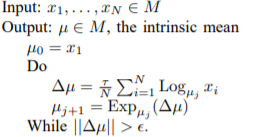

In [ ]:
!pip install sklearn
!pip install geomstats

In [3]:
import torch
import numpy as np
import logging
import math
from sklearn.base import BaseEstimator
import geomstats.backend as gs
import geomstats.errors as error
import geomstats.vectorization
from geomstats.geometry.euclidean import Euclidean, EuclideanMetric
from geomstats.geometry.riemannian_metric import RiemannianMetric


EPSILON = 1e-4

class Frechet_Mean():
  def variance(self,points, base_point, weights=None, point_type="vector"):
      """Variance of (weighted) points wrt a base point."""

      n_points = geomstats.vectorization.get_n_points(points, point_type)

      if weights is None:
          weights = gs.ones((n_points,))

      sum_weights = gs.sum(weights)
      sq_dists = metric.squared_dist(base_point, points)
      var = weights * sq_dists

      var = gs.sum(var)
      var /= sum_weights

      return var


  def f_mean(self,points, weights=None, point_type="vector"):
      """Compute the weighted linear mean.
      The linear mean is the Frechet mean when points:
      - lie in a Euclidean space with Euclidean metric,
      - lie in a Minkowski space with Minkowski metric.
      """
      if isinstance(points, list):
          points = gs.stack(points, axis=0)
      if isinstance(weights, list):
          weights = gs.array(weights)
      n_points = geomstats.vectorization.get_n_points(points, point_type)
      if weights is None:
          weights = gs.ones((n_points,))
      sum_weights = gs.sum(weights)

      einsum_str = "...,...j->...j"
      if point_type == "matrix":
          einsum_str = "...,...jk->...jk"

      weighted_points = gs.einsum(einsum_str, weights, points)

      mean = gs.sum(weighted_points, axis=0) / sum_weights
      return mean


  def gradient_descent(self,points, metric, weights, max_iter, point_type, epsilon, initial_step_size, verbose):
      """Perform default gradient descent."""
      if point_type == "vector":
          points = gs.to_ndarray(points, to_ndim=2)
          einsum_str = "n,nj->j"
      else:
          points = gs.to_ndarray(points, to_ndim=3)
          einsum_str = "n,nij->ij"
      n_points = gs.shape(points)[0]

      if weights is None:
          weights = gs.ones((n_points,))

      mean = points[0]

      if n_points == 1:
          return mean

      sum_weights = gs.sum(weights)
      sq_dists_between_iterates = []
      iteration = 0
      sq_dist = 0.0
      var = 0.0

      norm_old = gs.linalg.norm(points)
      step = initial_step_size
      #_n_points = gs.array([[2.0, 1.0], [-2.0, -4.0], [-5.0, 1.0]])
      #result = metric.squared_norm(_n_points,None)
      #print(metric,result)
      while iteration < max_iter:
          
          logs = metric.log(point=points, base_point=mean)
          logs=gs.array(logs)
          var = gs.sum(gs.sqrt(EuclideanMetric.norm(logs, mean)) * weights) / gs.sum(weights)

          tangent_mean = gs.einsum(einsum_str, weights, logs)
          tangent_mean /= sum_weights
          norm = gs.linalg.norm(tangent_mean)

          sq_dist = gs.sqrt(metric.norm(tangent_mean, mean))
          sq_dists_between_iterates.append(sq_dist)

          var_is_0 = gs.isclose(var, 0.0)
          sq_dist_is_small = gs.less_equal(sq_dist, epsilon * metric.dim)
          condition = ~gs.logical_or(var_is_0, sq_dist_is_small)
          if not (condition or iteration == 0):
              break

          estimate_next = metric.exp(step * tangent_mean, mean)
          mean = estimate_next
          iteration += 1

          if norm < norm_old:
              norm_old = norm
          elif norm > norm_old:
              step = step / 2.0

      if iteration == max_iter:
          logging.warning(
              "Maximum number of iterations {} reached. "
              "The mean may be inaccurate".format(max_iter)
          )

      if verbose:
          logging.info(
              "n_iter: {}, final variance: {}, final dist: {}".format(
                  iteration, var, sq_dist
              )
          )

      return mean

if __name__=='__main__':
  frechet=Frechet_Mean()
  points=np.asarray([[-0.58831187, -0.02677797,  0.80819062],[-0.55208236, -0.02669815,  0.83336203]],dtype=np.float32)
  metric=EuclideanMetric
  mean=frechet.f_mean(points)
  print('Frechet Mean:',mean)
  print("=========================================================")
  weights=None
  max_iter=100
  point_type="vector"
  epsilon=EPSILON
  initial_step_size=5
  verbose=True
  dim=2
  metric=EuclideanMetric(dim)
  gradient_mean=frechet.gradient_descent(points, metric, weights, max_iter, point_type, epsilon, initial_step_size, verbose)
  print("Gradient Descent for Intrinsic Mean: ",gradient_mean)

INFO: Using numpy backend
INFO: n_iter: 100, final variance: 1.0000286732700217, final dist: 0.1565888306948323


Frechet Mean: [-0.57019711 -0.02673806  0.82077634]
Gradient Descent for Intrinsic Mean:  [-0.59033398 -0.02678242  0.80678571]
